# setup

In [1]:
# Hackernews GitHub Project Timeline Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import time
from dateutil.parser import parse
from tqdm.notebook import tqdm
import re
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from urllib.parse import urlparse
import os

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")


In [2]:
# 1. Load the Hackernews data
def load_hn_data(filepath):
    """Load Hackernews story data from CSV."""
    df = pd.read_csv(filepath)

    # Convert Unix timestamp to datetime
    df['submission_date'] = pd.to_datetime(df['date'], unit='s')

    # Extract GitHub username and repo name from URL
    def extract_github_info(url):
        try:
            if not isinstance(url, str) or 'github.com' not in url:
                return None, None

            parsed = urlparse(url)
            if parsed.netloc != 'github.com':
                return None, None

            path_parts = [p for p in parsed.path.split('/') if p]
            if len(path_parts) >= 2:
                return path_parts[0], path_parts[1]
            return None, None
        except:
            return None, None

    # Apply extraction to create new columns
    df[['github_username', 'github_repo']] = df.apply(
        lambda row: pd.Series(extract_github_info(row['url'])), axis=1
    )

    # Filter only GitHub repositories
    github_df = df[df['github_username'].notna() & df['github_repo'].notna()].copy()

    # Create full repo name column (username/repo)
    github_df['full_repo_name'] = github_df['github_username'] + '/' + github_df['github_repo']

    return github_df


In [3]:
# 2. Fetch GitHub repository metadata
def fetch_github_repo_metadata(repo_list, token=None):
    """
    Fetch metadata for GitHub repositories, focusing on creation dates.

    Args:
        repo_list: List of repositories in format 'username/reponame'
        token: GitHub API token (optional but recommended to avoid rate limits)

    Returns:
        DataFrame with repository metadata
    """
    headers = {}
    if token:
        headers['Authorization'] = f'token {token}'
    else:
        print("Warning: No GitHub token provided. API rate limits may apply.")

    repo_data = []

    for repo in tqdm(repo_list, desc="Fetching GitHub metadata"):
        try:
            url = f'https://api.github.com/repos/{repo}'
            response = requests.get(url, headers=headers)

            if response.status_code == 200:
                data = response.json()
                repo_info = {
                    'full_repo_name': repo,
                    'created_at': data.get('created_at'),
                    'updated_at': data.get('updated_at'),
                    'stars': data.get('stargazers_count', 0),
                    'forks': data.get('forks_count', 0),
                    'language': data.get('language'),
                    'description': data.get('description')
                }
                repo_data.append(repo_info)
            else:
                print(f"Failed to fetch data for {repo}: {response.status_code}")

            # Respect GitHub's rate limit
            time.sleep(1)

        except Exception as e:
            print(f"Error fetching data for {repo}: {str(e)}")

    # Create DataFrame from collected data
    metadata_df = pd.DataFrame(repo_data)

    # Convert string dates to datetime
    if not metadata_df.empty:
        metadata_df['repo_created_at'] = pd.to_datetime(metadata_df['created_at'])
        metadata_df['repo_updated_at'] = pd.to_datetime(metadata_df['updated_at'])

    return metadata_df


In [4]:
# 3. Merge HN data with GitHub metadata
def merge_datasets(hn_df, github_df):
    """Merge Hackernews data with GitHub repo metadata."""
    # Merge on the full repo name
    merged_df = hn_df.merge(github_df, on='full_repo_name', how='left')

    # Ensure both datetime fields have the same timezone handling
    # They should both be UTC by now, but this is a safeguard
    if 'submission_date' in merged_df.columns and 'repo_created_at' in merged_df.columns:
        # Make sure both are timezone aware with UTC
        if merged_df['submission_date'].dt.tz is None:
            merged_df['submission_date'] = merged_df['submission_date'].dt.tz_localize('UTC')
        if merged_df['repo_created_at'].dt.tz is None:
            merged_df['repo_created_at'] = merged_df['repo_created_at'].dt.tz_localize('UTC')

    # Calculate time difference between repo creation and HN submission
    merged_df['days_difference'] = (merged_df['submission_date'] - merged_df['repo_created_at']).dt.total_seconds() / (60 * 60 * 24)

    # Flag for submission timing relative to repo creation
    merged_df['submitted_before_creation'] = merged_df['days_difference'] < 0

    # Create time buckets
    conditions = [
        (merged_df['days_difference'] < 0),
        (merged_df['days_difference'] == 0),
        (merged_df['days_difference'] > 0) & (merged_df['days_difference'] <= 7),
        (merged_df['days_difference'] > 7) & (merged_df['days_difference'] <= 30),
        (merged_df['days_difference'] > 30) & (merged_df['days_difference'] <= 90),
        (merged_df['days_difference'] > 90) & (merged_df['days_difference'] <= 365),
        (merged_df['days_difference'] > 365)
    ]

    choices = [
        'Before Creation',
        'Same Day',
        'First Week',
        'First Month',
        '1-3 Months',
        '3-12 Months',
        'Over a Year'
    ]

    merged_df['time_bucket'] = np.select(conditions, choices, default='Unknown')

    return merged_df

In [12]:
plt.rcParams.update({'font.size': 25, 'xtick.labelsize': 20, 'ytick.labelsize': 20})
fontsize = 25

# 4. Visualizations
def create_visualizations(merged_df):
    """Create various visualizations to analyze the data."""
    # Filter out rows with missing creation dates
    df = merged_df.dropna(subset=['repo_created_at']).copy()

    if len(df) == 0:
        print("No valid data available for visualization after filtering.")
        return

    # 1. Histogram of time differences
    plt.figure(figsize=(14, 8))

    # Focus on a reasonable range (-30 to 365 days)
    filtered_df = df[(df['days_difference'] >= -300) & (df['days_difference'] <= 965)]

    sns.histplot(filtered_df['days_difference'], bins=50, kde=True)
    plt.title('Time Difference Between GitHub Repo Creation and HN Submission', fontsize=fontsize)
    plt.xlabel('Days (negative = submitted before creation, positive = after creation)', fontsize=fontsize)
    plt.ylabel('Count', fontsize=fontsize)
    plt.axvline(x=0, color='red', linestyle='--', label='Creation Date')
    plt.legend()
    plt.tight_layout()
    plt.savefig('histogram_time_difference.png')
    plt.show()

    # 2. Scatter plot timeline
    plt.figure(figsize=(14, 8))

    # Filter extreme outliers for better visualization
    scatter_df = df[(df['days_difference'] >= -300) & (df['days_difference'] <= 965)]

    plt.scatter(scatter_df['repo_created_at'], scatter_df['days_difference'], alpha=0.7)
    plt.title('Time to HN Submission vs. GitHub Repo Creation Date', fontsize=fontsize)
    plt.xlabel('GitHub Repo Creation Date', fontsize=fontsize)
    plt.ylabel('Days Until HN Submission', fontsize=fontsize)
    plt.axhline(y=0, color='red', linestyle='--', label='Same Day')
    plt.legend()

    # Format x-axis to show years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())

    plt.tight_layout()
    plt.savefig('scatter_timeline.png')
    plt.show()

    # 3. Box plots by time bucket
    plt.figure(figsize=(14, 8))

    # Order buckets logically
    bucket_order = [
        'Before Creation',
        'Same Day',
        'First Week',
        'First Month',
        '1-3 Months',
        '3-12 Months',
        'Over a Year'
    ]

    bucket_counts = df['time_bucket'].value_counts().reindex(bucket_order).fillna(0)

    # Add count to labels
    bucket_labels = [f"{bucket} (n={int(bucket_counts[bucket])})" for bucket in bucket_order]

    sns.countplot(data=df, x='time_bucket', order=bucket_order)
    plt.title('Distribution of Submissions by Time Bucket', fontsize=fontsize)
    plt.xlabel('Time Relative to Repo Creation', fontsize=fontsize)
    plt.ylabel('Count', fontsize=fontsize)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('boxplot_time_buckets.png')
    plt.show()

    # 4. Cumulative distribution function (CDF)
    plt.figure(figsize=(14, 8))

    # Calculate empirical CDF for positive days (submissions after creation)
    positive_days = df[df['days_difference'] >= 0]['days_difference']

    if len(positive_days) > 0:
        # Prepare values for CDF
        sorted_data = np.sort(positive_days)
        y_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

        plt.plot(sorted_data, y_values, marker='.', linestyle='none', alpha=0.5)
        plt.title('Cumulative Distribution of Time to HN Submission', fontsize=fontsize)
        plt.xlabel('Days After GitHub Repo Creation', fontsize=fontsize)
        plt.ylabel('Cumulative Proportion', fontsize=fontsize)

        # Add annotations for specific percentiles
        percentiles = [0.25, 0.5, 0.75, 0.9]
        for p in percentiles:
            days = np.percentile(sorted_data, p * 100)
            plt.axhline(y=p, color='red', linestyle='--', alpha=0.3)
            plt.axvline(x=days, color='red', linestyle='--', alpha=0.3)
            plt.text(days + 5, p, f'{p*100:.0f}% within {days:.0f} days',
                    verticalalignment='center')

        plt.grid(True)
        plt.tight_layout()
        plt.savefig('cdf_submission_time.png')
        plt.show()
    else:
        print("No positive day differences available for CDF plot")

    # 5. Year-over-year analysis
    # Extract year from repo creation date
    df['creation_year'] = df['repo_created_at'].dt.year

    if df['creation_year'].nunique() > 1:
        plt.figure(figsize=(14, 8))
        sns.boxplot(data=df, x='creation_year', y='days_difference')
        plt.title('Time to HN Submission by GitHub Repo Creation Year', fontsize=fontsize)
        plt.xlabel('GitHub Repo Creation Year', fontsize=fontsize)
        plt.ylabel('Days Until HN Submission', fontsize=fontsize)
        plt.axhline(y=0, color='red', linestyle='--', label='Same Day')
        plt.legend()
        plt.tight_layout()
        plt.savefig('boxplot_by_year.png')
        plt.show()
    else:
        print("Not enough years for year-over-year analysis")

    return

# Additional Analysis: Investigating early submissions
def analyze_early_submissions(merged_df):
    """Analyze cases where submission happened before repo creation."""
    early_df = merged_df[merged_df['days_difference'] < 0].copy()

    if len(early_df) == 0:
        print("No early submissions found.")
        return

    print(f"Found {len(early_df)} submissions that occurred before repo creation")
    print("\nTop 5 earliest submissions (relative to creation):")
    early_sorted = early_df.sort_values('days_difference')

    # Display details of early submissions
    for idx, row in early_sorted.head().iterrows():
        days = abs(row['days_difference'])
        print(f"- {row['title']}")
        print(f"  Submitted: {row['submission_date'].strftime('%Y-%m-%d')}")
        print(f"  Repo created: {row['repo_created_at'].strftime('%Y-%m-%d')}")
        print(f"  {days:.1f} days before creation")
        print()

    # Histogram of early submissions
    plt.figure(figsize=(12, 6))
    sns.histplot(early_df['days_difference'], bins=20)
    plt.title('Distribution of Submissions Before Repo Creation', fontsize=fontsize)
    plt.xlabel('Days Before Creation (negative values)', fontsize=fontsize)
    plt.ylabel('Count', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig('early_submissions_histogram.png')
    plt.show()

    return early_df

# running

In [13]:
# 1. Load HN data
print("Loading Hackernews data...")
HN_STORIES_GH_CSV = '/content/drive/MyDrive/datasets/muict-naist-senior/rq1/rq1_freq_analysis/rq1_stories_github.csv'
hn_data = load_hn_data(HN_STORIES_GH_CSV)
print(f"Found {len(hn_data)} GitHub repositories in HN submissions")

# Show sample of the data
print("\nSample of HN data:")
print(hn_data.head())

# Ask for GitHub token
from google.colab import userdata
github_token = userdata.get('GITHUB_TOKEN')


Loading Hackernews data...
Found 300 GitHub repositories in HN submissions

Sample of HN data:
   discussion_id                                              title  \
0       31355348  BlindAI: Open-source, fast and privacy-friendl...   
1       31405976          OpenAI Codex Python to C++ Code Generator   
2       31831437                                   Gemini with IPFS   
3       31846593  YaLM-100B: Pretrained language model with 100B...   
4       32458048  Paradigms of Artificial Intelligence Programmi...   

                                           url        date  \
0  https://github.com/mithril-security/blindai  1652368380   
1    https://github.com/alxschwrz/codex_py2cpp  1652761021   
2     https://github.com/JonStratton/geminipfs  1655865106   
3          https://github.com/yandex/YaLM-100B  1655974826   
4          https://github.com/norvig/paip-lisp  1660472194   

      submission_date   github_username   github_repo  \
0 2022-05-12 15:13:00  mithril-security       bl

In [7]:
# 2. Fetch GitHub metadata
print("\nFetching GitHub repository metadata...")
repo_list = hn_data['full_repo_name'].unique().tolist()

# Check if cached data exists
HN_GH_METADATA_CSV = '/content/drive/MyDrive/datasets/muict-naist-senior/rq3/rq3_creation_submission/rq3_github_metadata.csv'

# Load existing csv
if os.path.exists(HN_GH_METADATA_CSV):
    github_data = pd.read_csv(HN_GH_METADATA_CSV)
    github_data['repo_created_at'] = pd.to_datetime(github_data['repo_created_at'])
    github_data['repo_updated_at'] = pd.to_datetime(github_data['repo_updated_at'])
    print(f"Loaded metadata for {len(github_data)} repositories from cache")

# Retrieve repository metadata
else:
    github_data = fetch_github_repo_metadata(repo_list, github_token)
    # Cache the data
    github_data.to_csv(HN_GH_METADATA_CSV, index=False)

# Show sample of GitHub data
print("\nSample of GitHub metadata:")
print(github_data.head())



Fetching GitHub repository metadata...
Loaded metadata for 290 repositories from cache

Sample of GitHub metadata:
             full_repo_name            created_at            updated_at  \
0  mithril-security/blindai  2022-02-06T14:07:35Z  2025-02-25T16:58:11Z   
1    alxschwrz/codex_py2cpp  2022-05-15T16:07:22Z  2025-02-28T11:32:29Z   
2     JonStratton/geminipfs  2022-05-06T00:47:09Z  2024-08-13T03:39:55Z   
3          yandex/YaLM-100B  2022-06-22T16:24:16Z  2025-03-03T07:59:43Z   
4          norvig/paip-lisp  2018-02-05T22:02:34Z  2025-03-01T22:31:19Z   

   stars  forks     language  \
0    505     35         Rust   
1    497     46       Python   
2     22      0       Python   
3   3751    299       Python   
4   7267    707  Common Lisp   

                                         description  \
0  Confidential AI deployment with secure enclave...   
1  Converts python code into c++ by using OpenAI ...   
2                                Gemini IPFS Gateway   
3     Pretrained

In [8]:
# 3. Merge datasets
print("\nMerging datasets...")
merged_data = merge_datasets(hn_data, github_data)


Merging datasets...



Basic statistics:
Total repositories: 300
Repositories with valid creation dates: 293
Average days between creation and submission: 111.86
Median days between creation and submission: 19.00

Distribution of submissions by time bucket:
time_bucket
First Week         103
First Month         64
1-3 Months          56
3-12 Months         48
Over a Year         21
Before Creation      1
Name: count, dtype: int64

Creating visualizations...


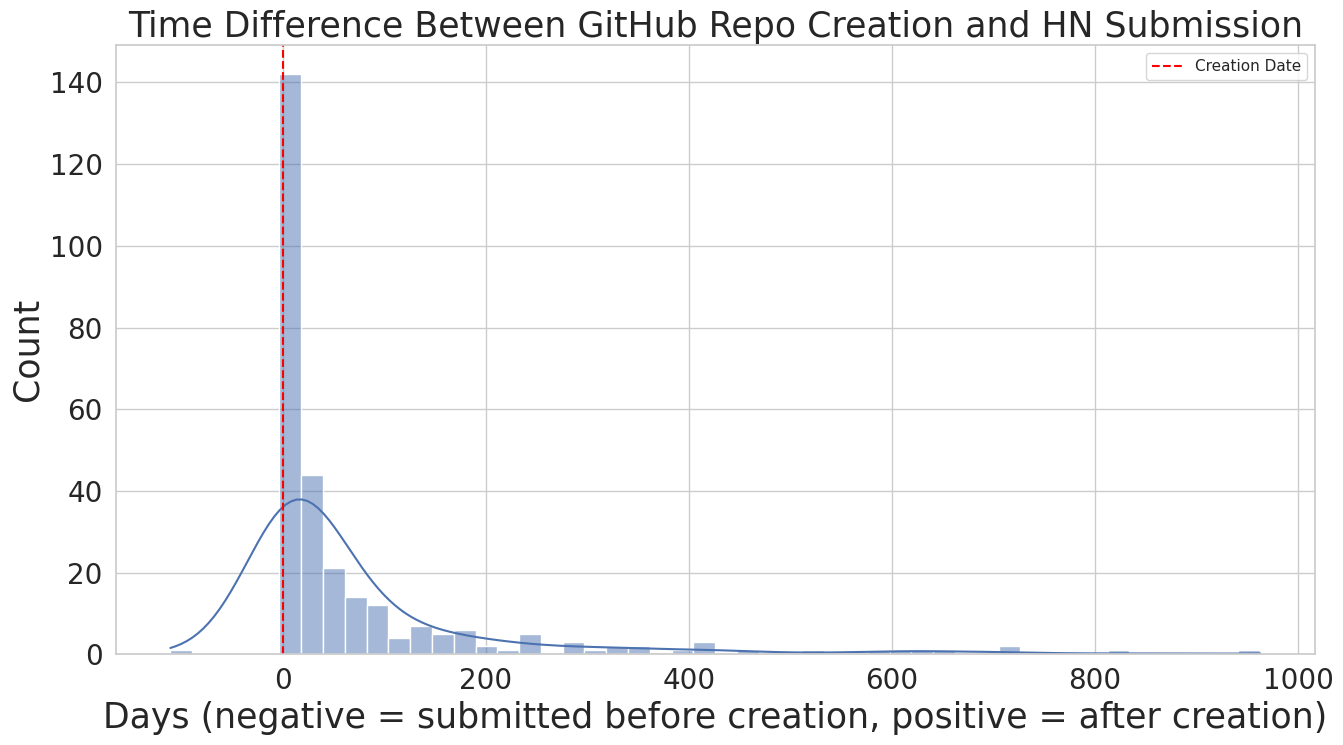

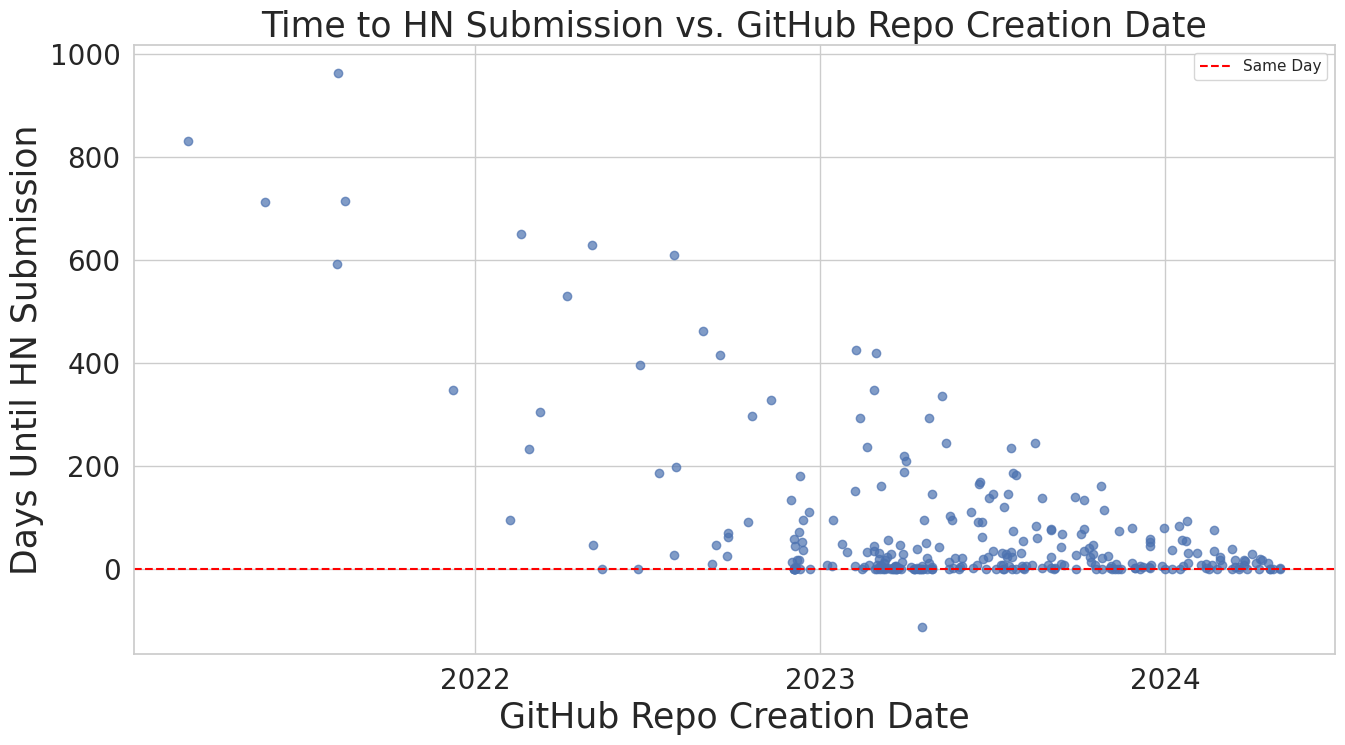

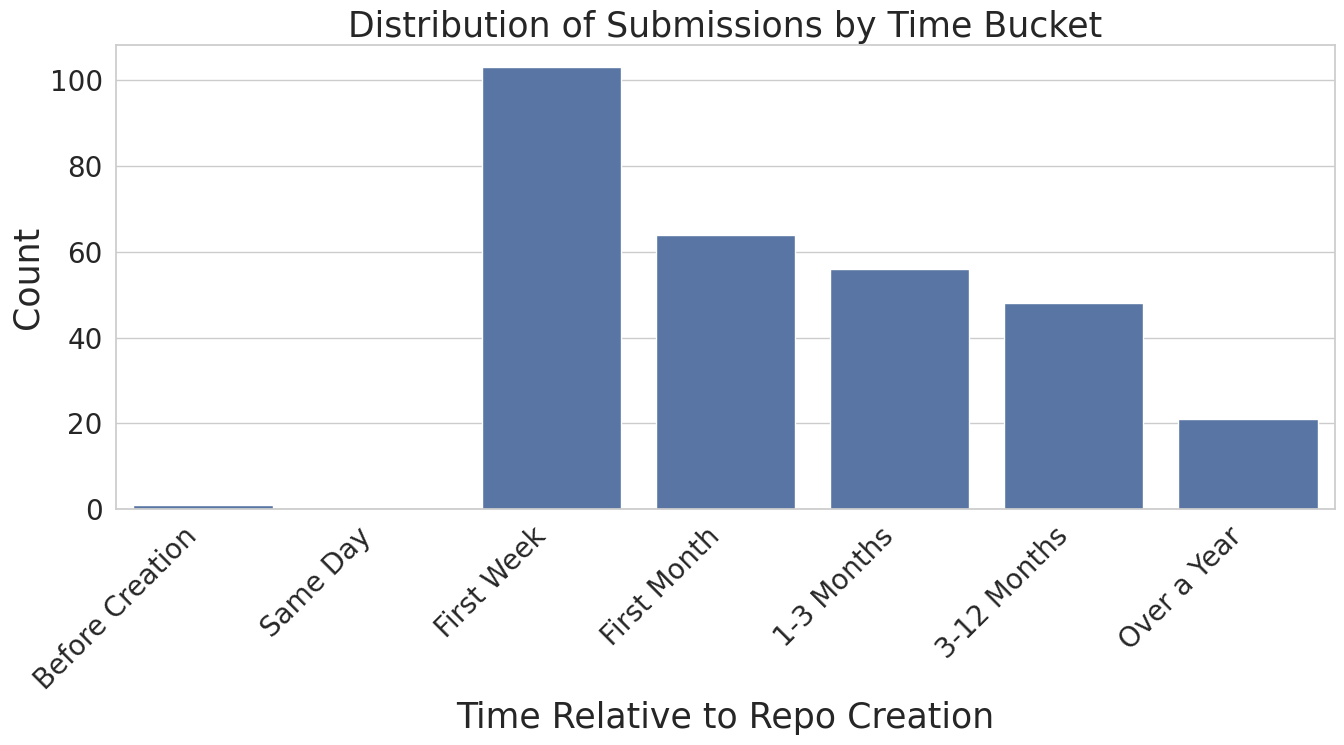

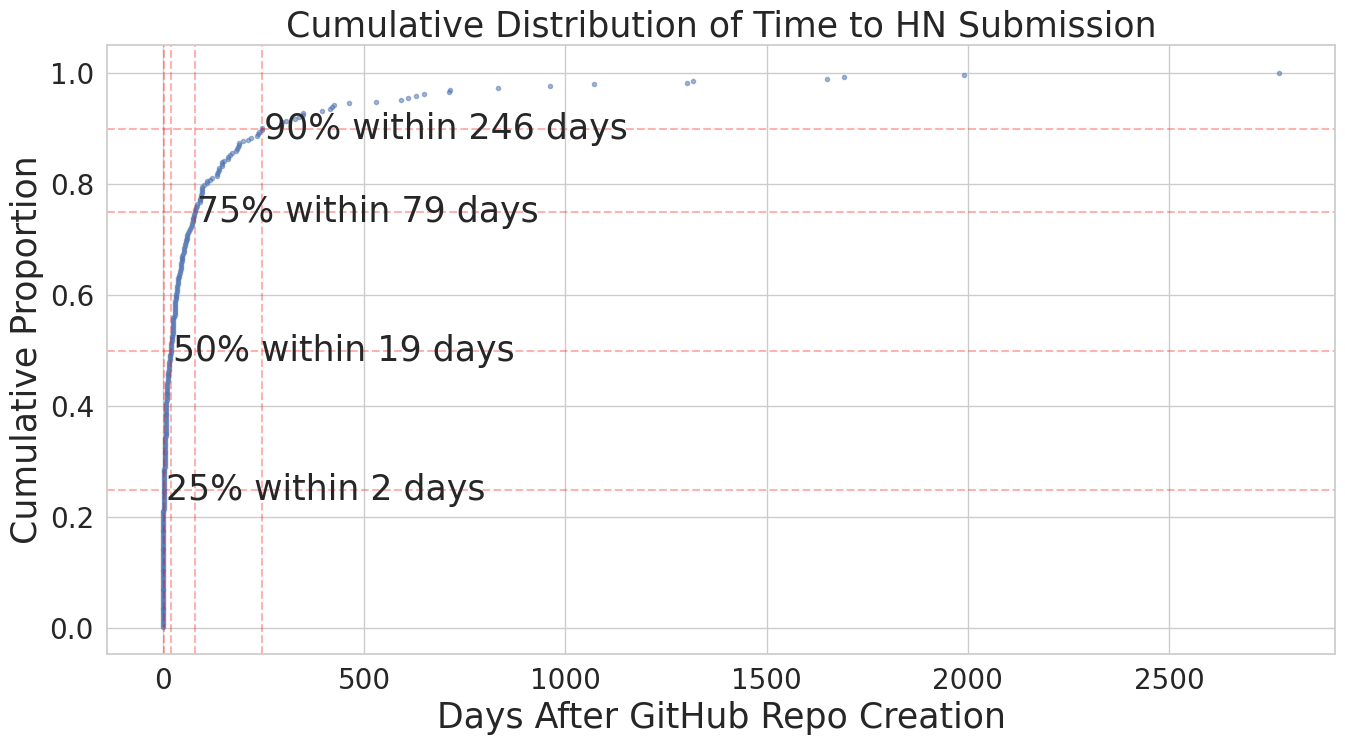

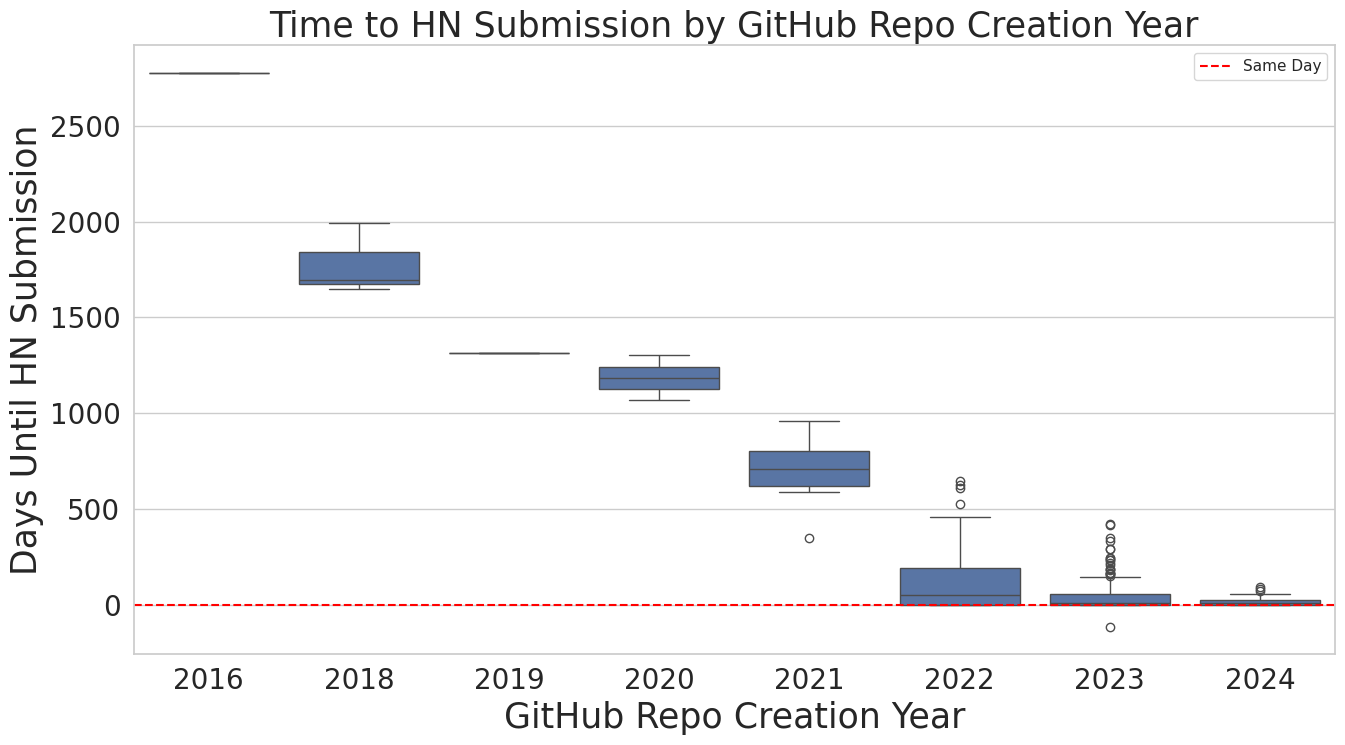


Analyzing submissions before repo creation...
Found 1 submissions that occurred before repo creation

Top 5 earliest submissions (relative to creation):
- GPT3/DALL-E2 in Discord, chat like ChatGPT, generate images, and more
  Submitted: 2022-12-29
  Repo created: 2023-04-18
  110.7 days before creation



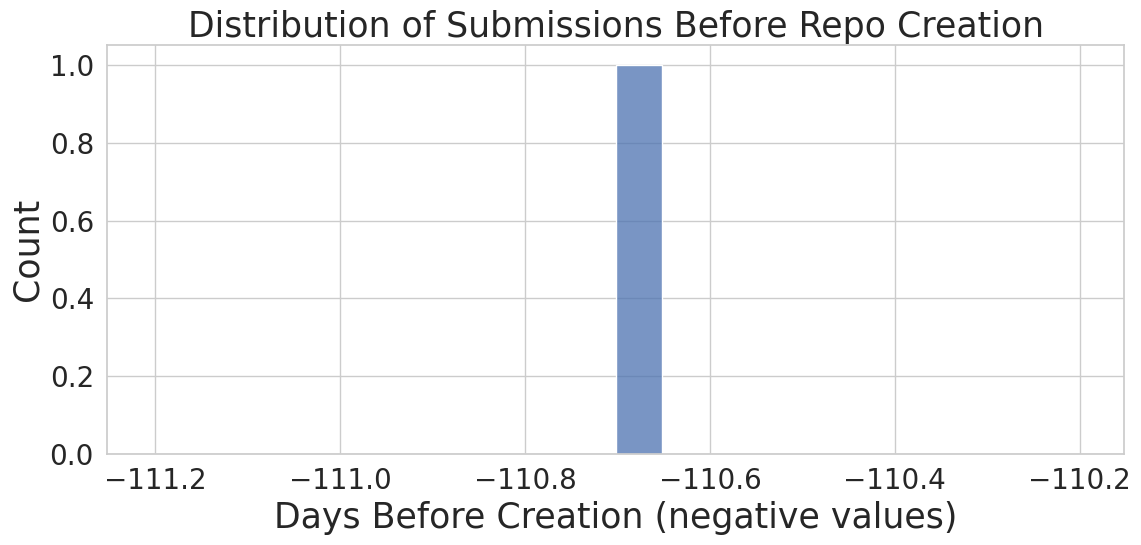

In [14]:
# Basic statistics
valid_data = merged_data.dropna(subset=['repo_created_at'])
print("\nBasic statistics:")
print(f"Total repositories: {len(merged_data)}")
print(f"Repositories with valid creation dates: {len(valid_data)}")

if len(valid_data) > 0:
    print(f"Average days between creation and submission: {valid_data['days_difference'].mean():.2f}")
    print(f"Median days between creation and submission: {valid_data['days_difference'].median():.2f}")

    # Distribution of time buckets
    print("\nDistribution of submissions by time bucket:")
    print(valid_data['time_bucket'].value_counts(dropna=False))

    # 4. Create visualizations
    print("\nCreating visualizations...")
    create_visualizations(merged_data)

    # 5. Analyze early submissions (before repo creation)
    print("\nAnalyzing submissions before repo creation...")
    analyze_early_submissions(merged_data)
else:
    print("No valid data available for analysis (missing creation dates)")

In [ ]:
# Save the final dataset
HN_GH_METADATA_STORY_MERGED_CSV = '/content/drive/MyDrive/datasets/muict-naist-senior/rq3/rq3_creation_submission/rq3_github_hn_merged.csv'
merged_data.to_csv(HN_GH_METADATA_STORY_MERGED_CSV, index=False)
print(f'\nAnalysis complete! Results saved to {HN_GH_METADATA_STORY_MERGED_CSV}')


Creating visualizations...


NameError: name 'filtered_df' is not defined

<Figure size 1400x800 with 0 Axes>